>介绍两种不同的归一化技术：移位对数变换和皮尔逊残差的解析近似。移位对数有利于稳定方差，以利于后续降维和差异表达基因的识别。皮尔森近似残差可以保留生物学差异，并鉴定稀有细胞类型。

In [8]:
import omicverse as ov
import scanpy as sc

ov.utils.ov_plot_set()
adata = ov.read("data/sc01.after_quality_control.h5ad")

#adata = sc.read(
#    filename="s4d8_quality_control.h5ad",
#    backup_url="https://figshare.com/ndownloader/files/40014331",
#)

In [9]:
print(adata)

AnnData object with n_obs × n_vars = 2447 × 17053
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'nUMIs', 'mito_perc', 'detected_genes', 'doublet_score', 'predicted_doublet', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'


### 移位对数

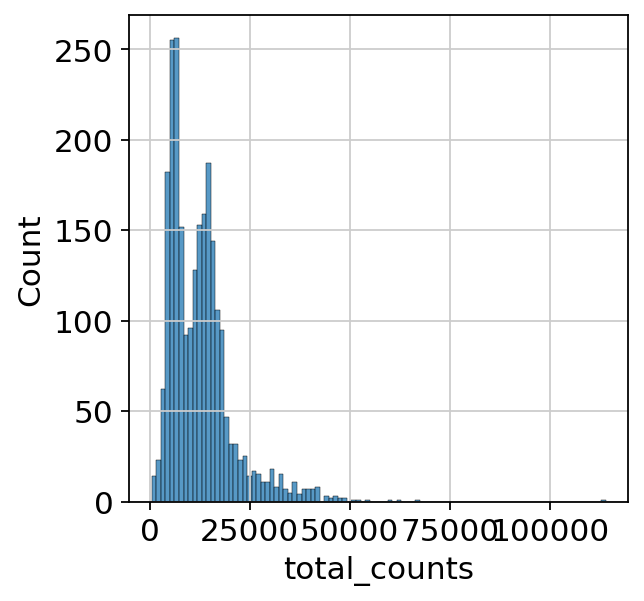

In [10]:
import seaborn as sns
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False)

使用pp.normalized_total 调用 scanpy 的移位对数

In [11]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

normalizing counts per cell
    finished (0:00:00)


In [12]:
scales_counts

{'X': <2447x17053 sparse matrix of type '<class 'numpy.float32'>'
 	with 3191910 stored elements in Compressed Sparse Row format>,
 'norm_factor': array([16846.,  4413.,  9762., ...,  4191., 40756., 27274.], dtype=float32)}

使用hist图来对比归一化前后的计数变化

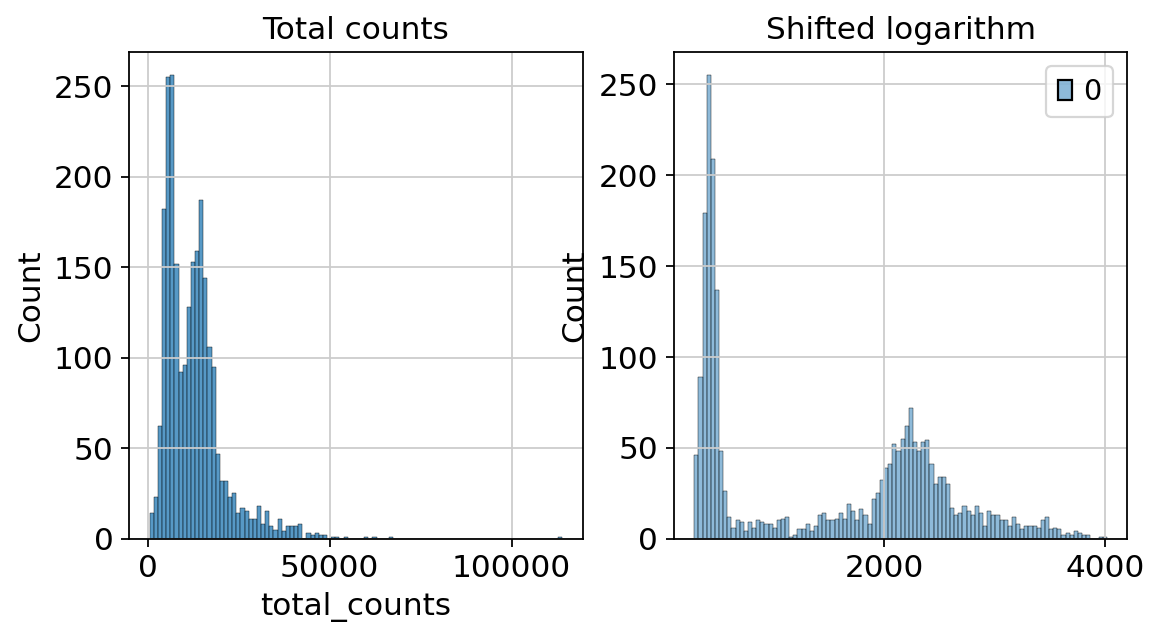

In [13]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

### 皮尔森近似残差

scRNA-seq数据中的细胞间变异包括了生物异质性以及技术效应。而移位计数并不能很好的排除两种不同变异来源的混淆误差。皮尔森近似残差利用了“正则化负二项式回归”的皮尔森残差来计算数据中潜在的技术噪音，将计数深度添加为广义线性模型中的协变量，而在不同的归一化方法的测试中，皮尔森残差法可以消除计数效应带来的误差，并且保留了数据集中的细胞异质性。

In [14]:
from scipy.sparse import csr_matrix
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

computing analytic Pearson residuals on adata.X
    finished (0:00:00)


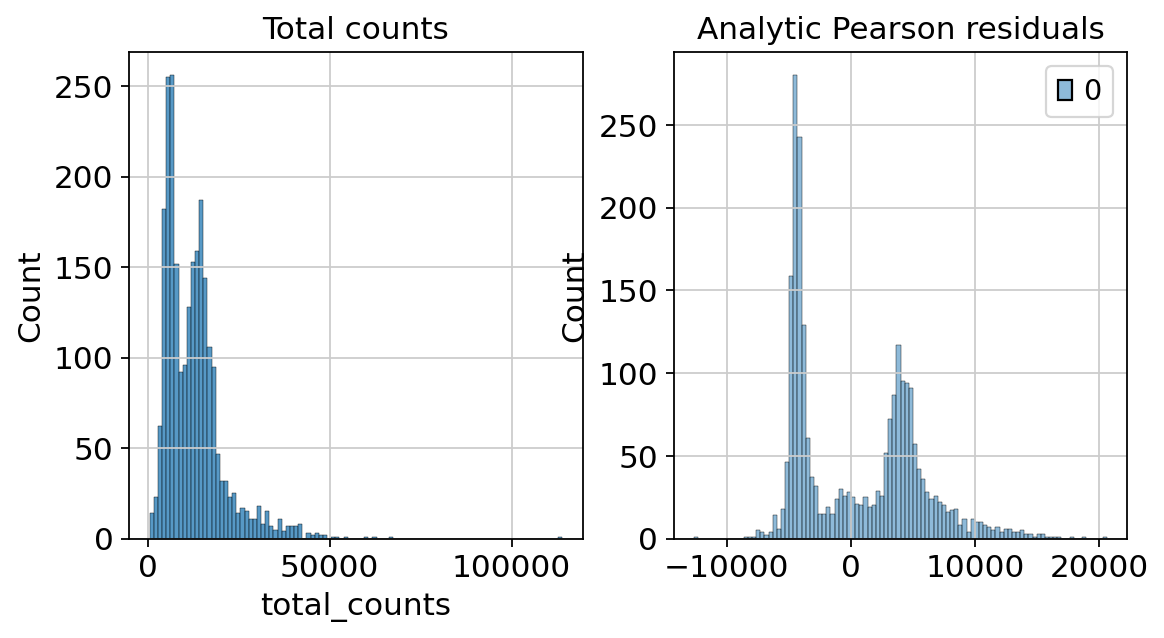

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("Analytic Pearson residuals")
plt.show()

### 一键式归一化

在omicverse中提供了预处理函数pp.preprocess，该方法可直接计算移位对数或皮尔森残差，方法内同时包括了基于移位对数/皮尔森残差的高可变基因的选择方法，高可变基因会在下一节的教程中进行讲解

### omicverse 位移对数

在omicverse中，我们设置mode='shiftlog|pearson'即可完成移位对数的计算，一般来说，默认的target_sum=50*1e4，同时高可变基因定义为前2000个,需要注意的是，当omicverse的版本小于1.4.13时，mode的参数只能设置为scanpy或pearson，scanpy与shiftlog的意义是相同的

In [16]:
adata_log=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,)
adata_log

Begin robust gene identification
After filtration, 17053/17053 genes are kept. Among 17053 genes, 17053 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['IGKC', 'HBB', 'MALAT1', 'HBA2', 'IGLC3']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
End of size normalization: shiftlog and HVGs selection pearson


AnnData object with n_obs × n_vars = 2447 × 17053
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'nUMIs', 'mito_perc', 'detected_genes', 'doublet_score', 'predicted_doublet', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'log1p', 'hvg'
    layers: 'log1p_norm', 'analytic_pearson_residuals', 'counts'

### omicverse 皮尔森近似残差

可以设置mode='pearson|pearson'来完成皮尔森近似残差的计算，此时我们不需要输入target_sum，需要注意的是，当omicverse的版本小于1.4.13时，mode的参数只能设置为scanpy或pearson

In [17]:
adata_pearson=ov.pp.preprocess(adata,mode='pearson|pearson',n_HVGs=2000,)
adata_pearson

Begin robust gene identification
After filtration, 17053/17053 genes are kept. Among 17053 genes, 17053 genes are robust.
End of robust gene identification.
Begin size normalization: pearson and HVGs selection pearson
computing analytic Pearson residuals on adata.X
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
End of size normalization: pearson and HVGs selection pearson


AnnData object with n_obs × n_vars = 2447 × 17053
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'nUMIs', 'mito_perc', 'detected_genes', 'doublet_score', 'predicted_doublet', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'pearson_residuals_normalization', 'hvg'
    layers: 'log1p_norm', 'analytic_pearson_residuals', 'counts'

#### 比一下两种分析的结果

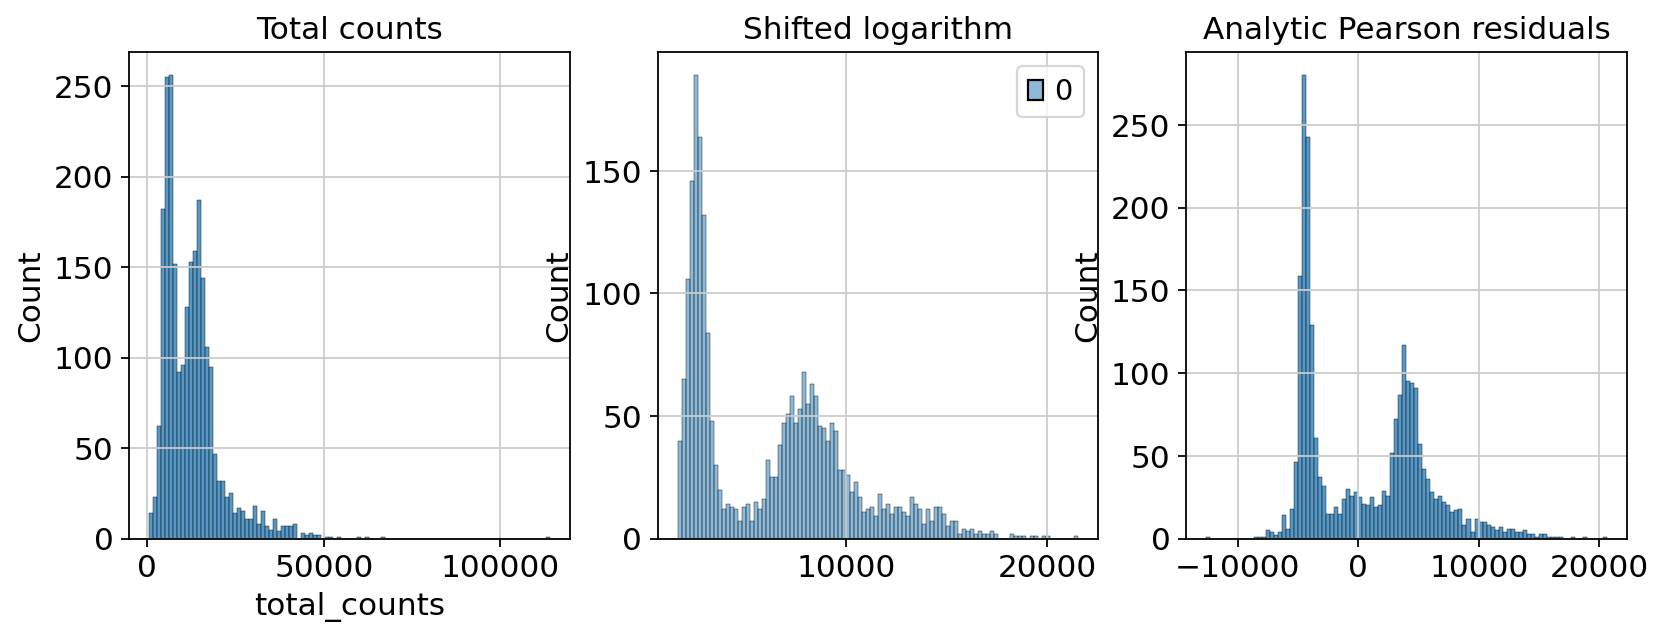

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")

p2 = sns.histplot(
    adata_log.X.sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("Shifted logarithm")

p3 = sns.histplot(
    adata_pearson.X.sum(1), bins=100, kde=False, ax=axes[2]
)
axes[2].set_title("Analytic Pearson residuals")
plt.show()